# Forecasting electricity demand on french market

### Situation

“Enercoop”, a cooperative company specializing in renewable energies, has expanded thanks to the liberalization of the electricity market in France. However, most of these renewable energies are intermittent, making it difficult to forecast electricity production capacity. What's more, user demand for electricity varies over time, and depends on parameters such as the weather (temperature, luminosity, etc.). Here, the challenge is to match supply and demand.

### What is renewable energy?
Energy is said to be renewable when it comes from sources that nature constantly renews, as opposed to non-renewable energy whose stocks run out.

Renewable energies come from 2 major natural sources: the Sun (which drives the water cycle, tides, wind and plant growth) and the Earth (which releases heat).

Nicknamed “clean energies” or “green energies”, their exploitation generates very little waste and polluting emissions, but their energy power is much lower than that of non-renewable energies.

## The challenges and objectives of electricity demand forecasting :

Electricity cannot be stored, and overall production on the French power grid must be strictly equal to consumption at all times. Any change in electricity demand or production at any point on the network has instant repercussions for the entire power system. The system must therefore constantly adapt to satisfy the supply-demand balance.


In [1]:
# !pip install pmdarima

In [2]:
# Import principals library

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import shapiro
from IPython.display import clear_output
from time import time

import itertools
import warnings
warnings.filterwarnings('ignore')

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Version of python library


print("Jupyter Notebook : " + str(pd.__version__))
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Matplotlib : " + str(matplotlib.__version__))
print("Seaborn : " + str(sns.__version__))
print("Statsmodels : " + str(sm.__version__))

Jupyter Notebook : 2.2.2
Pandas : 2.2.2
Numpy : 1.26.4
Matplotlib : 3.9.0
Seaborn : 0.13.2
Statsmodels : 0.14.2


## Processing the dataset exported from the RTE website

In [4]:
# Download dataset on 'consommation.csv'
data_conso = pd.read_csv('p9_data/consommation.csv', sep=';', parse_dates=[0]) #pare_dates convert the object in the first column in datetime object
data_conso.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Unnamed: 22
0,0000-00,Données consolidées,Grand-Est,11346,8643.0,1120,22.0,2,1095,565,...,4545,6711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000-00,Données consolidées,Nouvelle-Aquitaine,5289,4179.0,164,NaN,0,164,419,...,4578,711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000-00,Données consolidées,Auvergne-Rhône-Alpes,11622,8382.0,334,6.0,11,316,2630,...,6834,4483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000-00,Données consolidées,Bourgogne-Franche-Comté,467,NaN,124,NaN,0,123,89,...,2188,-1724.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000-00,Données consolidées,Bretagne,535,NaN,182,NaN,4,178,59,...,2443,-1915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Mensual data for electricity total consumption only in France

conso = data_conso.copy()
conso = conso[["Mois", "Territoire", "Consommation totale"]]
conso = conso[conso['Territoire'] == 'France']
conso.drop('Territoire', axis=1, inplace=True)
conso.rename(columns={'Mois': 'mois', 'Consommation totale': 'consommation'}, inplace=True)


In [6]:
#Display mensual total consumption of electricity
display(conso.head())
display(conso.shape)

,mois,consommation
6,0000-00,49559
13,2012-01,51086
14,2012-02,54476
15,2012-03,43156
16,2012-04,40176


(99, 2)

In [7]:
#Look for outliers like the one in the first line
conso.drop(6, axis=0, inplace=True)

In [8]:
# Change type of the first column in datetime
conso['mois'] = pd.to_datetime(conso['mois'])
conso.set_index('mois', inplace=True)
conso

,consommation
mois,
2012-01-01,51086
2012-02-01,54476
2012-03-01,43156
2012-04-01,40176
2012-05-01,35257
...,...
2019-10-01,36482
2019-11-01,44180
2019-12-01,47096


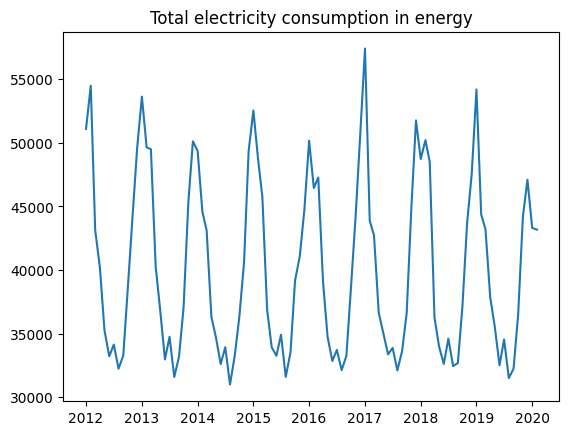

In [9]:
# Visualize total consumption of electricity
plt.plot(conso.consommation)
plt.title("Total electricity consumption in energy")
plt.savefig("p9_graphic/conso_elect.png")
plt.show()

In the above time series, we can identtify fairly regular cycles over time and of similar amplitude. Monthly consumtion data will be corrected for the temperature effect using linear regression. It is necessary to extract data due to electric heating over the same period in order to see the influence of other factor like behavior of customers, holiday and economic activity in the consumptin of electricity.

In [10]:
# Resampling data per year
conso.resample('Y').sum()

,consommation
mois,
2012-12-31,489517
2013-12-31,494842
2014-12-31,465150
2015-12-31,476050
2016-12-31,483219
2017-12-31,482008
2018-12-31,478431
2019-12-31,473739
2020-12-31,86473


## Processing the dataset exported from the Cegibat website

In [31]:
# Load data
data_dju = pd.read_csv('p9_data/dju.csv', encoding= "utf-8", sep = ";", skiprows=11, header=None)
data_dju.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,NaN,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
1,2019.0,"404,9","268,3","233,1","168,5","117,9",14,0,0,0,0,0,0,"1206,6"
2,2018.0,"303,4","432,6","314,3","119,7","55,9","8,1",0,"3,3","34,3","122,4","282,5","325,9","2002,2"
3,2017.0,"467,9","278,4","206,1","182,6",75,"9,4",1,"6,8","62,6","99,4","282,6",369,"2040,6"
4,2016.0,"364,4","321,6","321,1","212,1","88,1","27,5","5,7","3,2","11,7",176,"285,6","390,8","2207,3"


We will remove 2019 data because, we have null values on winter months

In [32]:
# Remove the 2 first lines and the last series
data_dju.drop([0, 1], axis=0, inplace=True)
data_dju.drop([13], axis=1, inplace=True)

In [33]:
# The first series is the index
data_dju[0] = data_dju[0].astype(int)
data_dju.set_index([0], inplace=True)

In [34]:
data_dju.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
2018,"303,4","432,6","314,3","119,7","55,9","8,1",0,"3,3","34,3","122,4","282,5","325,9"
2017,"467,9","278,4","206,1","182,6",75,"9,4",1,"6,8","62,6","99,4","282,6",369
2016,"364,4","321,6","321,1","212,1","88,1","27,5","5,7","3,2","11,7",176,"285,6","390,8"
2015,392,"365,7","275,5","141,1","91,5","15,8","6,9","6,1","71,9","176,9",195,"248,1"
2014,"324,4","281,9","223,9","135,5","100,2","19,1","8,3","19,3",16,"92,3","222,6","368,2"


Now we will transform it in temporal matrix

In [35]:
#Transformation of data

dju = {'mois': [], 'dju_chauffage': []}

for year in data_dju.index.values:
    for month in data_dju.columns:
        dju['mois'].append(f"{year}-{month}")
        dju['dju_chauffage'].append(data_dju.loc[year, month])

dju = pd.DataFrame(dju)
dju['mois'] = pd.to_datetime(dju['mois'])

In [36]:
# set index with mois columns
dju.set_index('mois', inplace=True)

In [37]:
# Monthly data 
display(dju.head())
display(dju.shape)


,dju_chauffage
mois,
2018-01-01,"303,4"
2018-02-01,"432,6"
2018-03-01,"314,3"
2018-04-01,"119,7"
2018-05-01,"55,9"


(120, 1)

In [38]:
dju['dju_chauffage'] = dju['dju_chauffage'].str.replace(',', '.').astype(float)

In [39]:
dju

,dju_chauffage
mois,
2018-01-01,303.4
2018-02-01,432.6
2018-03-01,314.3
2018-04-01,119.7
2018-05-01,55.9
...,...
2009-08-01,0.9
2009-09-01,26.9
2009-10-01,149.6


In [42]:
dju_res = dju.resample('M').sum()

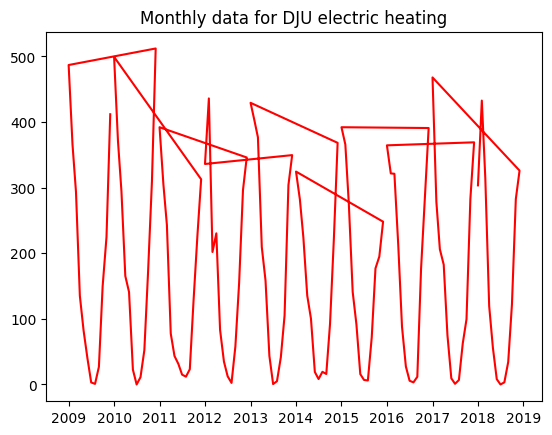

In [40]:
#Display dataset
plt.plot(dju.dju_chauffage, color='r')
plt.title("Monthly data for DJU electric heating")
plt.savefig("p9_graphic/dju_elec_heating.png")
plt.show()


In [44]:
dju_res

,dju_chauffage
mois,
2009-01-31,486.8
2009-02-28,365.7
2009-03-31,293.2
2009-04-30,135.1
2009-05-31,82.2
...,...
2018-08-31,3.3
2018-09-30,34.3
2018-10-31,122.4


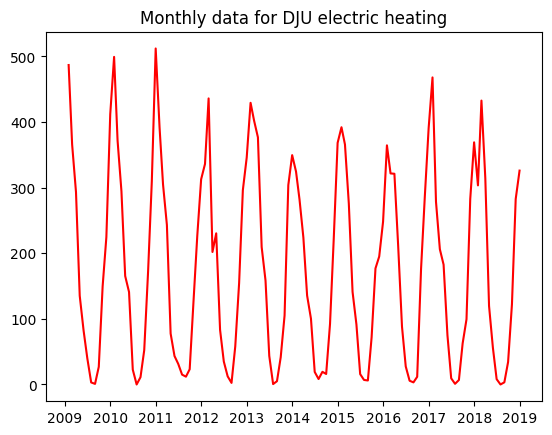

In [43]:
#Display dataset
plt.plot(dju_res.dju_chauffage, color='r')
plt.title("Monthly data for DJU electric heating")
plt.savefig("p9_graphic/dju_elec_heating.png")
plt.show()


This time series naturally takes into account seasonality linked to climatic conditions. Our monthly cycles therefore evolve according to temperature, and other exogenous factors not taken into account in the study, such as humidity, the impact of pollution, etc. Finally, UDDs summed over a period can be used to calculate a building's heating and cooling requirements.

In [47]:
#Merge the two data
df = pd.merge(conso, dju, how='inner', on='mois')
df

,consommation,dju_chauffage
mois,,
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3
...,...,...
2018-08-01,32451,3.3
2018-09-01,32683,34.3
2018-10-01,37102,122.4


In [48]:

df.isna().any()

consommation     False
dju_chauffage    False
dtype: bool

Les années 2019 et 2020 ne peuvent pas être validées pour l'analyse, des valeurs manquantes sont présentes sur ces deux années. Avec une jointure 'inner' l'exclusion est automatiquement réalisée.

In [49]:
#Statistiques descriptives de l'échantillon
df.describe().T

,count,mean,std,min,25%,50%,75%,max
consommation,84.0,40109.726190,7135.547804,31004.0,33696.75,37082.5,45914.250,57406.0
dju_chauffage,84.0,174.596429,143.731842,0.0,32.60,156.5,303.525,467.9



If we analyze the two graphs, we can see that higher heating consumption leads to higher electricity consumption. These two variables are therefore linked. With the working sample now complete, the next step is to correct the electricity consumption data for the temperature effect caused by heating. Linear regression will be used.